# Universe Machine mass functions

* SMF of the new UM when considering in-situ, ex-situ, and the sum of both compared to Songs SMF
* look at the scatter in M* and Mhalo
- for in-situ
- for in-situ + ex-situ
- for N most massive galaxies

TODO:
* Give song latest data (with extra fields)
* Once things are restructured get this ready for PR
* Cleanup figures
    *
* From talking to alexie, we don't just want the SMF of centrals. We want the SMF of everything.
    * I think this means not eveyrthing summed in, but just count all the centrals+sats
    * This is also way wrong compared to HSC data. work out what is up there.
* Richness vs scatter at fixed halo mass. So pick a mass bin, then plot richness (number of galaxies with mass > 10.8 ish, bin this) vs scatter.
* https://docs.google.com/document/d/1kRZUw_nHksmnfgu_u6OtERTrl_w-xgio5t7WndmFQPA/edit
* https://redwoodforest.slack.com/archives/D6UA26L6R/p1515102490000636

# Install and load data

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits

import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Local libs
import sys
sys.path.append("..")

import plots
import cluster_sum
import lib.stellar_mass_function as smf
from importlib import reload # for when I mess up local libs

In [2]:
datadir = os.getenv("dataDir") + "/universe_machine/"
catalog_file = "sfr_catalog_insitu_exsitu_0.712400_final_extended.npz"

catalog = np.load(datadir + catalog_file)
centrals = catalog["centrals"]
satellites = catalog["satellites"]

# Our data

Let's get a very broad sense of our data

In [4]:
print(centrals.dtype)
print(len(centrals))
print(len(satellites))
print(satellites[:10])
print(centrals[centrals['id'] == 8272347969])

[('id', '<i8'), ('upid', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('mp', '<f8'), ('sm', '<f8'), ('icl', '<f8'), ('sfr', '<f8'), ('mvir', '<f8'), ('rvir', '<f8'), ('rs', '<f8'), ('Halfmass_Scale', '<f8'), ('scale_of_last_MM', '<f8'), ('M200b', '<f8'), ('M200c', '<f8'), ('Acc_Rate_Inst', '<f8'), ('Acc_Rate_100Myr', '<f8'), ('Acc_Rate_1*Tdyn', '<f8'), ('Acc_Rate_2*Tdyn', '<f8'), ('Acc_Rate_Mpeak', '<f8'), ('Vmax@Mpeak', '<f8')]
385125
10809469
[ (8272347655, 8272347654,  13.83487,  18.749399,  16.14661 ,   1.98400000e+09,   3.11700000e+09,   2.31400000e+05,   0.00000000e+00,   6.41000000e-05,   1.34880000e+09,  25.014   ,  1.248,  0.281 ,  0.281 ,   1.34880000e+09,   1.34880000e+09,  0.    ,  0.     , -0.1056,  -0.1456,  0.    ,   30.41)
 (8272348262, 8272347732,  15.026  ,  17.7521  ,  17.388531,   1.98400000e+09,   2.26700000e+09,   1.15200000e+03,   0.00000000e+00,   2.51000000e-06,   1.34880000e+09,  25.014   ,  2.777,  0.6884,  0.6884,   1.34880000e+09,   1.252

385117 centrals without ICL of our 385125 samples


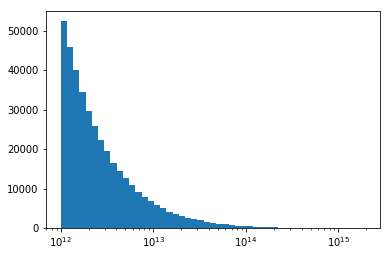

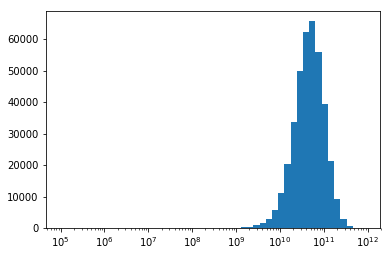

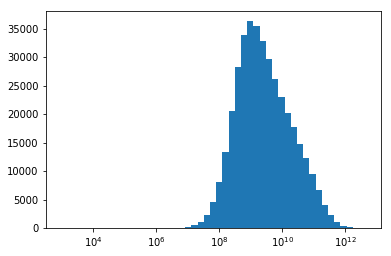

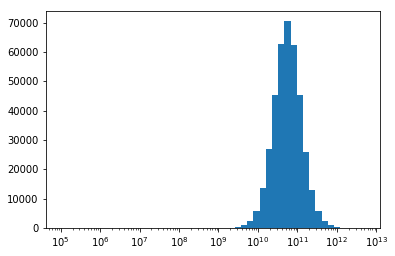

In [5]:
fig, ax = plt.subplots()
_ = ax.hist(centrals["mp"], bins = np.geomspace(np.amin(centrals["mp"]), np.amax(centrals["mp"]), 50))
_ = ax.set(xscale="log")

fig, ax = plt.subplots()
_ = ax.hist(centrals["sm"], bins = np.geomspace(np.amin(centrals["sm"]), np.amax(centrals["sm"]), 50))
_ = ax.set(xscale="log")

fcentrals = centrals[np.nonzero(centrals["icl"])[0]]
fig, ax = plt.subplots()
_ = ax.hist(fcentrals["icl"], bins = np.geomspace(np.amin(fcentrals["icl"]), np.amax(fcentrals["icl"]), 50))
_ = ax.set(xscale="log")
print(
    "{} centrals without ICL of our {} samples".format(len(np.nonzero(centrals["icl"])[0]), len(centrals))
)

fig, ax = plt.subplots()
_ = ax.hist(
    centrals["icl"] + centrals["sm"],
    bins = np.geomspace(
        np.amin(centrals["icl"]) + np.amin(centrals["sm"]),
        np.amax(centrals["icl"]) + np.amax(centrals["sm"]),
        50))
_ = ax.set(xscale="log")

# SMHM relations

Now let's plot the SM, halo mass relations for centrals

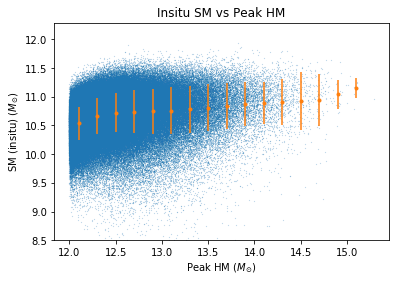

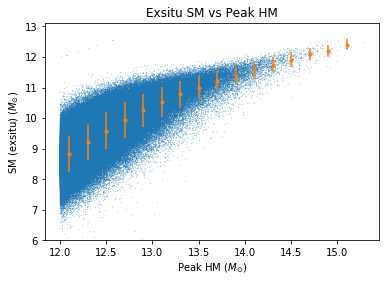

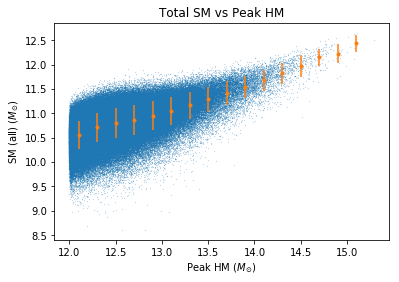

In [10]:
reload(plots)
ax = plots.dm_vs_insitu(centrals)
ax.set(ylim=8.5) # ignore crazy small galaxies

ax = plots.dm_vs_exsitu(centrals)
ax.set(ylim=6) # not sure why by default it ignores a bunch of data

plots.dm_vs_all_sm(centrals)

# SMHM for cluster

What happens if we start to plot this relation for multiple members of the cluster?

In [3]:
reload(cluster_sum)
data = {
    0: centrals,
    1: cluster_sum.centrals_with_satellites(centrals, satellites, 1),
    2: cluster_sum.centrals_with_satellites(centrals, satellites, 2),
    5: cluster_sum.centrals_with_satellites(centrals, satellites, 5),
    9: cluster_sum.centrals_with_satellites(centrals, satellites, 9),
    "all": cluster_sum.centrals_with_satellites(centrals, satellites, 0.9999),
}

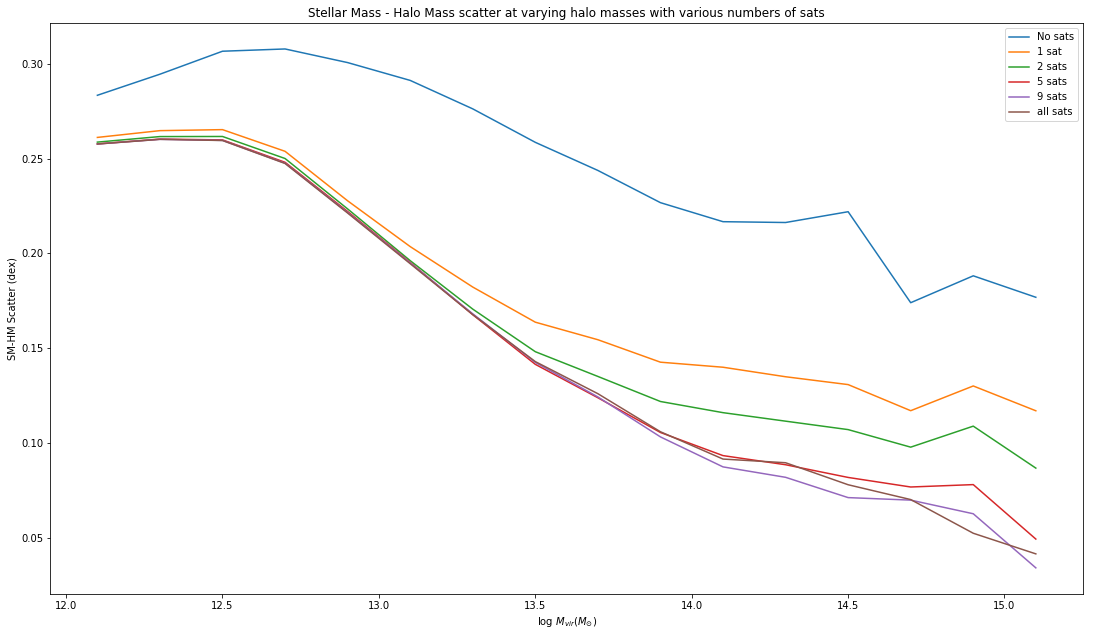

In [5]:
reload(plots)
plots.dm_vs_all_sm_error([data[0], data[1], data[2], data[5], data[9], data["all"]], 
                           labels = ["No sats", "1 sat", "2 sats", "5 sats", "9 sats", "all sats"])

# SMF

What does our SMF look like? (This is now right I think (see TODOs))

However, the output is badly wrong. 

In [66]:
hsc_smf_file_m10 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm10_smf_default.fits"
hsc_smf_file_m100 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm100_smf_default.fits"

m10_smf = astropy.io.fits.open(hsc_smf_file_m10)[1].data
m100_smf = astropy.io.fits.open(hsc_smf_file_m100)[1].data

In [67]:
print(m10_smf.dtype)
print(m10_smf)

(numpy.record, [('logm_mean', '>f8'), ('logm_0', '>f8'), ('logm_1', '>f8'), ('smf', '>f8'), ('smf_err', '>f8'), ('smf_low', '>f8'), ('smf_upp', '>f8')])
[ ( 10.45,  10.4,  10.5,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00)
 ( 10.55,  10.5,  10.6,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00)
 ( 10.65,  10.6,  10.7,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00)
 ( 10.75,  10.7,  10.8,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00)
 ( 10.85,  10.8,  10.9,   1.23958176e-07,   2.48352780e-08,  -2.47916352e-08,   2.72707987e-07)
 ( 10.95,  10.9,  11. ,   2.47916352e-07,   4.96449906e-08,   7.43749056e-08,   4.21457798e-07)
 ( 11.05,  11. ,  11.1,   4.95832704e-07,   9.92538264e-08,   1.48749811e-07,   8.42915597e-07)
 ( 11.15,  11.1,  11.2,   6.44582515e-06,   1.28947974e-06,   4.28895289e-06,   8.60269741e-06)
 ( 11.25,  11.2,  11.3,   3.94187000e-05,   7.88451825e-06,   2.95516291e-05, 

Dropped 0 galaxies with mass of 0


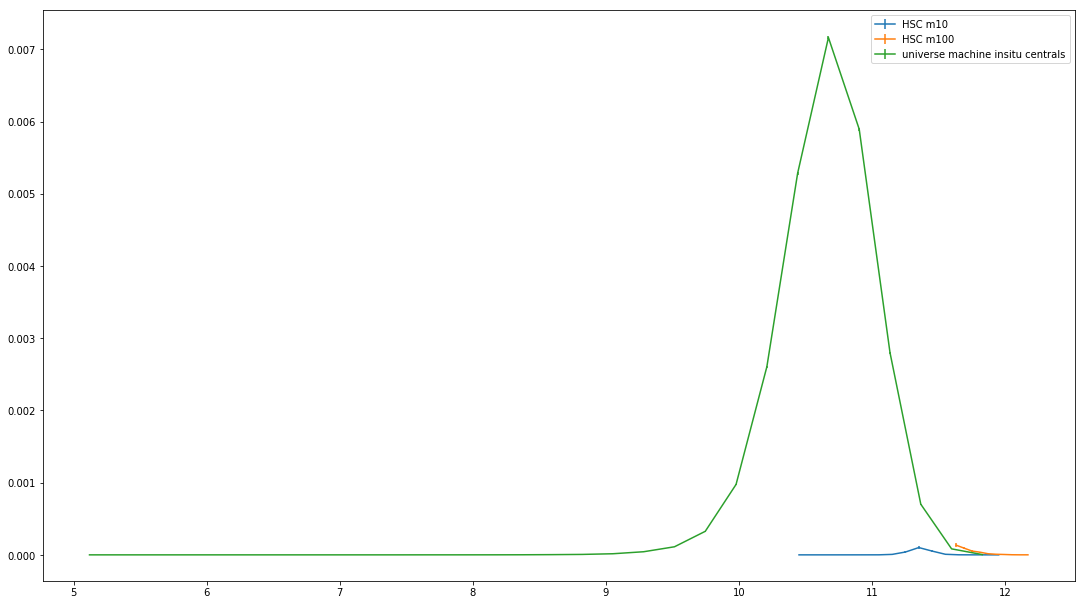

In [86]:
reload(smf)

def plot_sim_smf(stellar_masses, ax, label):

    nonzero_stellar_masses = np.log10(stellar_masses[stellar_masses != 0])
    print("Dropped {} galaxies with mass of 0".format(len(stellar_masses) - len(nonzero_stellar_masses)))

    sim_volume = 400**3 # https://redwoodforest.slack.com/archives/C5W6EQCAU/p1513187949000425 SMDPL
    num_bins = 30
    x, y, err = smf.compute_smf(
        nonzero_stellar_masses, sim_volume, num_bins, 
        np.min(nonzero_stellar_masses), np.max(nonzero_stellar_masses),
    )
    ax.errorbar(x, y, yerr = err, label=label)


fig, ax = plt.subplots()
ax.errorbar(m10_smf["logm_mean"], m10_smf["smf"], yerr = m10_smf["smf_err"], label="HSC m10")
ax.errorbar(m100_smf["logm_mean"], m100_smf["smf"], yerr = m100_smf["smf_err"], label="HSC m100")
plot_sim_smf(centrals["sm"], ax, "universe machine insitu centrals")
#plot_sim_smf(np.append(centrals["sm"] + centrals["icl"], satellites["sm"] + satellites["icl"]), ax, "all mass cents and sats")
#plot_sim_smf(centrals["sm"] + centrals["icl"], ax, "all mass cents")
ax.legend()
fig.set_size_inches(18.5, 10.5)

# Richness

What about richness? Does that have a relation with scatter at fixed halo mass

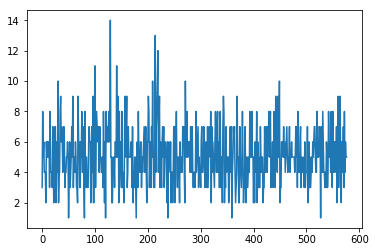

In [10]:
reload(cluster_sum)
minMassForRichness = 10**10.8
# I don't think this adds anything but am holding off on delting until I understand this properly again
binnedCentrals = centrals[(centrals["mp"] > pow(10, 14)) & (centrals["mp"] < pow(10, 14.1))]
richness = cluster_sum.get_richness(binnedCentrals, satellites, minMassForRichness)
plt.plot(richness)

No handles with labels found to put in legend.


[ 13.00043408  13.11482483  13.22921559  13.34360635  13.45799711
  13.57238786  13.68677862  13.80116938  13.91556014  14.02995089
  14.14434165  14.25873241  14.37312317  14.48751392  14.60190468
  14.71629544  14.8306862   14.94507695  15.05946771  15.17385847
  15.28824923]

At low richness scatter increases with richness - if those large satellites merged scatter would decrease.
Scatter peaks at an intermediate richness value that increases with halo mass
At high richness scatter decreases with richness - I don't know why



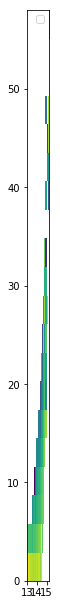

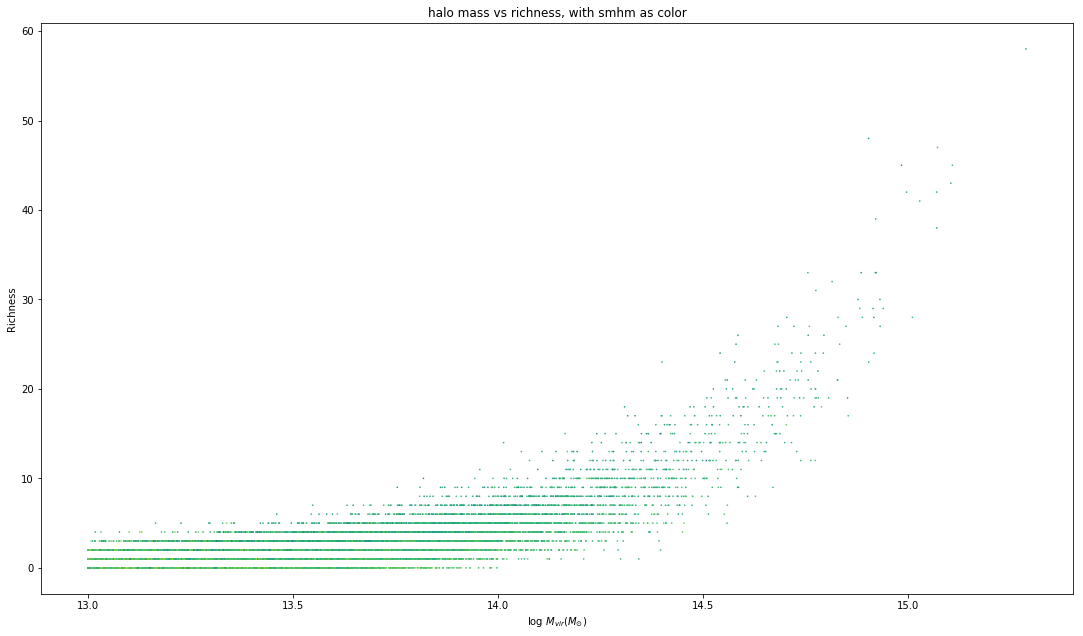

In [37]:
reload(plots)
# For each central halo
# Get the stellar mass, get sm/hm
# Get the richness
# plot!

plots.richness_vs_scatter(
    centrals[centrals["mp"] > 10**13], # Play with this...
    satellites,
    minMassForRichness,
    labels=labels)
print("""
At low richness scatter increases with richness - if those large satellites merged scatter would decrease.
Scatter peaks at an intermediate richness value that increases with halo mass
At high richness scatter decreases with richness - I don't know why
""")